In [28]:
import torch
import global_v as glv
from network_parser import parse
from datasets import loadXOR
from utils import learningStats
from datetime import datetime
import cnns
import argparse
import loss
import logging

max_accuracu = 0
min_loss = 1000

In [29]:
import matplotlib.pyplot as plt
import numpy as np
def save_fig(name):
    if str(name)[:3] == 'mem':
        np.save("figs/"+str(name),glv.mem_p_stat_ori)
    elif str(name)[:3] == 'out':
        np.save("figs/"+str(name),glv.output_stat_ori)
    elif str(name)[:3] == 'err':
        np.save("figs/"+str(name),glv.error_stat)
    elif str(name)[:3] == 'gra':
        np.save("figs/"+str(name),glv.grad_stat)
        
def plot_mov_fig():
    fig_num=4
    plt.clf()
    
    for key in glv.mem_p_stat_ori:
        
        if key == 'FC_1':
            count = 1
            layer_shape = np.shape(np.array(glv.mem_p_stat_ori[key]))
            cases_num = layer_shape[0]*layer_shape[1]*layer_shape[2]*layer_shape[3]
            cases_ori = np.array(glv.mem_p_stat_ori[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(cases_ori)
#             plt.colorbar()
            plt.axis('off')

            count = count + 1
            output_ori = np.array(glv.output_stat_ori[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(output_ori)
#             plt.colorbar()
            plt.axis('off')

            count = count + 1
        elif key == 'FC_2':
            count = 5
            layer_shape = np.shape(np.array(glv.mem_p_stat_ori[key]))
            cases_num = layer_shape[0]*layer_shape[1]*layer_shape[2]*layer_shape[3]
            cases_ori = np.array(glv.mem_p_stat_ori[key]).reshape(cases_num,layer_shape[4])
            print("cases_num: ", cases_num)
            plt.subplot(2,fig_num,count)
            plt.imshow(cases_ori)
#             plt.colorbar()
            plt.axis('off')

            count = count + 1
            output_ori = np.array(glv.output_stat_ori[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(output_ori)
#             plt.colorbar()
            plt.axis('off')
def plot_grad_fig():
    fig_num=4
    
    for key in glv.grad_stat:
        
        if key == 'FC_1':
            count = 3
            layer_shape = np.shape(np.array(glv.grad_stat[key]))
            cases_num = layer_shape[0]*layer_shape[1]*layer_shape[2]*layer_shape[3]

            grad_stat = np.array(glv.grad_stat[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(grad_stat)
#             plt.colorbar()
            plt.axis('off')

            count = count + 1
            error_stat = np.array(glv.error_stat[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(error_stat)
#             plt.colorbar()
            plt.axis('off')
            count = count + 1
        elif key == 'FC_2':
            count = 7
            layer_shape = np.shape(np.array(glv.grad_stat[key]))
            cases_num = layer_shape[0]*layer_shape[1]*layer_shape[2]*layer_shape[3]

            grad_stat = np.array(glv.grad_stat[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(grad_stat)
#             plt.colorbar()
            plt.axis('off')

            count = count + 1
            error_stat = np.array(glv.error_stat[key]).reshape(cases_num,layer_shape[4])
            plt.subplot(2,fig_num,count)
            plt.imshow(error_stat)
#             plt.colorbar()
            plt.axis('off')
            count = count + 1

loading XOR
Network Structure:
linear
FC_1
input shape: [10, 2, 1, 1, 50]
weight shape:  [2, 40]
output shape: [10, 40, 1, 1, 50]
-----------------------------------------
linear
FC_2
input shape: [10, 40, 1, 1, 50]
weight shape:  [40, 20]
output shape: [10, 20, 1, 1, 50]
-----------------------------------------
linear
FC_3
input shape: [10, 20, 1, 1, 50]
weight shape:  [20, 1]
output shape: [10, 1, 1, 1, 50]
-----------------------------------------
-----------------------------------------
tensor([ 0.9136,  0.4241,  0.1628, -0.9330,  0.7727, -0.2057,  0.4578,  0.4525,
         0.5443, -0.9709])
torch.Size([10, 2, 1, 1, 50])
torch.Size([10])
times_count: 0
scale: 1.0000, bias: 0.0000
cases_num:  200
times_count: 1
scale: 0.9899, bias: -0.0100
cases_num:  200
times_count: 2
scale: 0.9798, bias: -0.0200
cases_num:  200
times_count: 3
scale: 0.9697, bias: -0.0300
cases_num:  200
times_count: 4
scale: 0.9597, bias: -0.0399
cases_num:  200
times_count: 5
scale: 0.9498, bias: -0.0497
cases

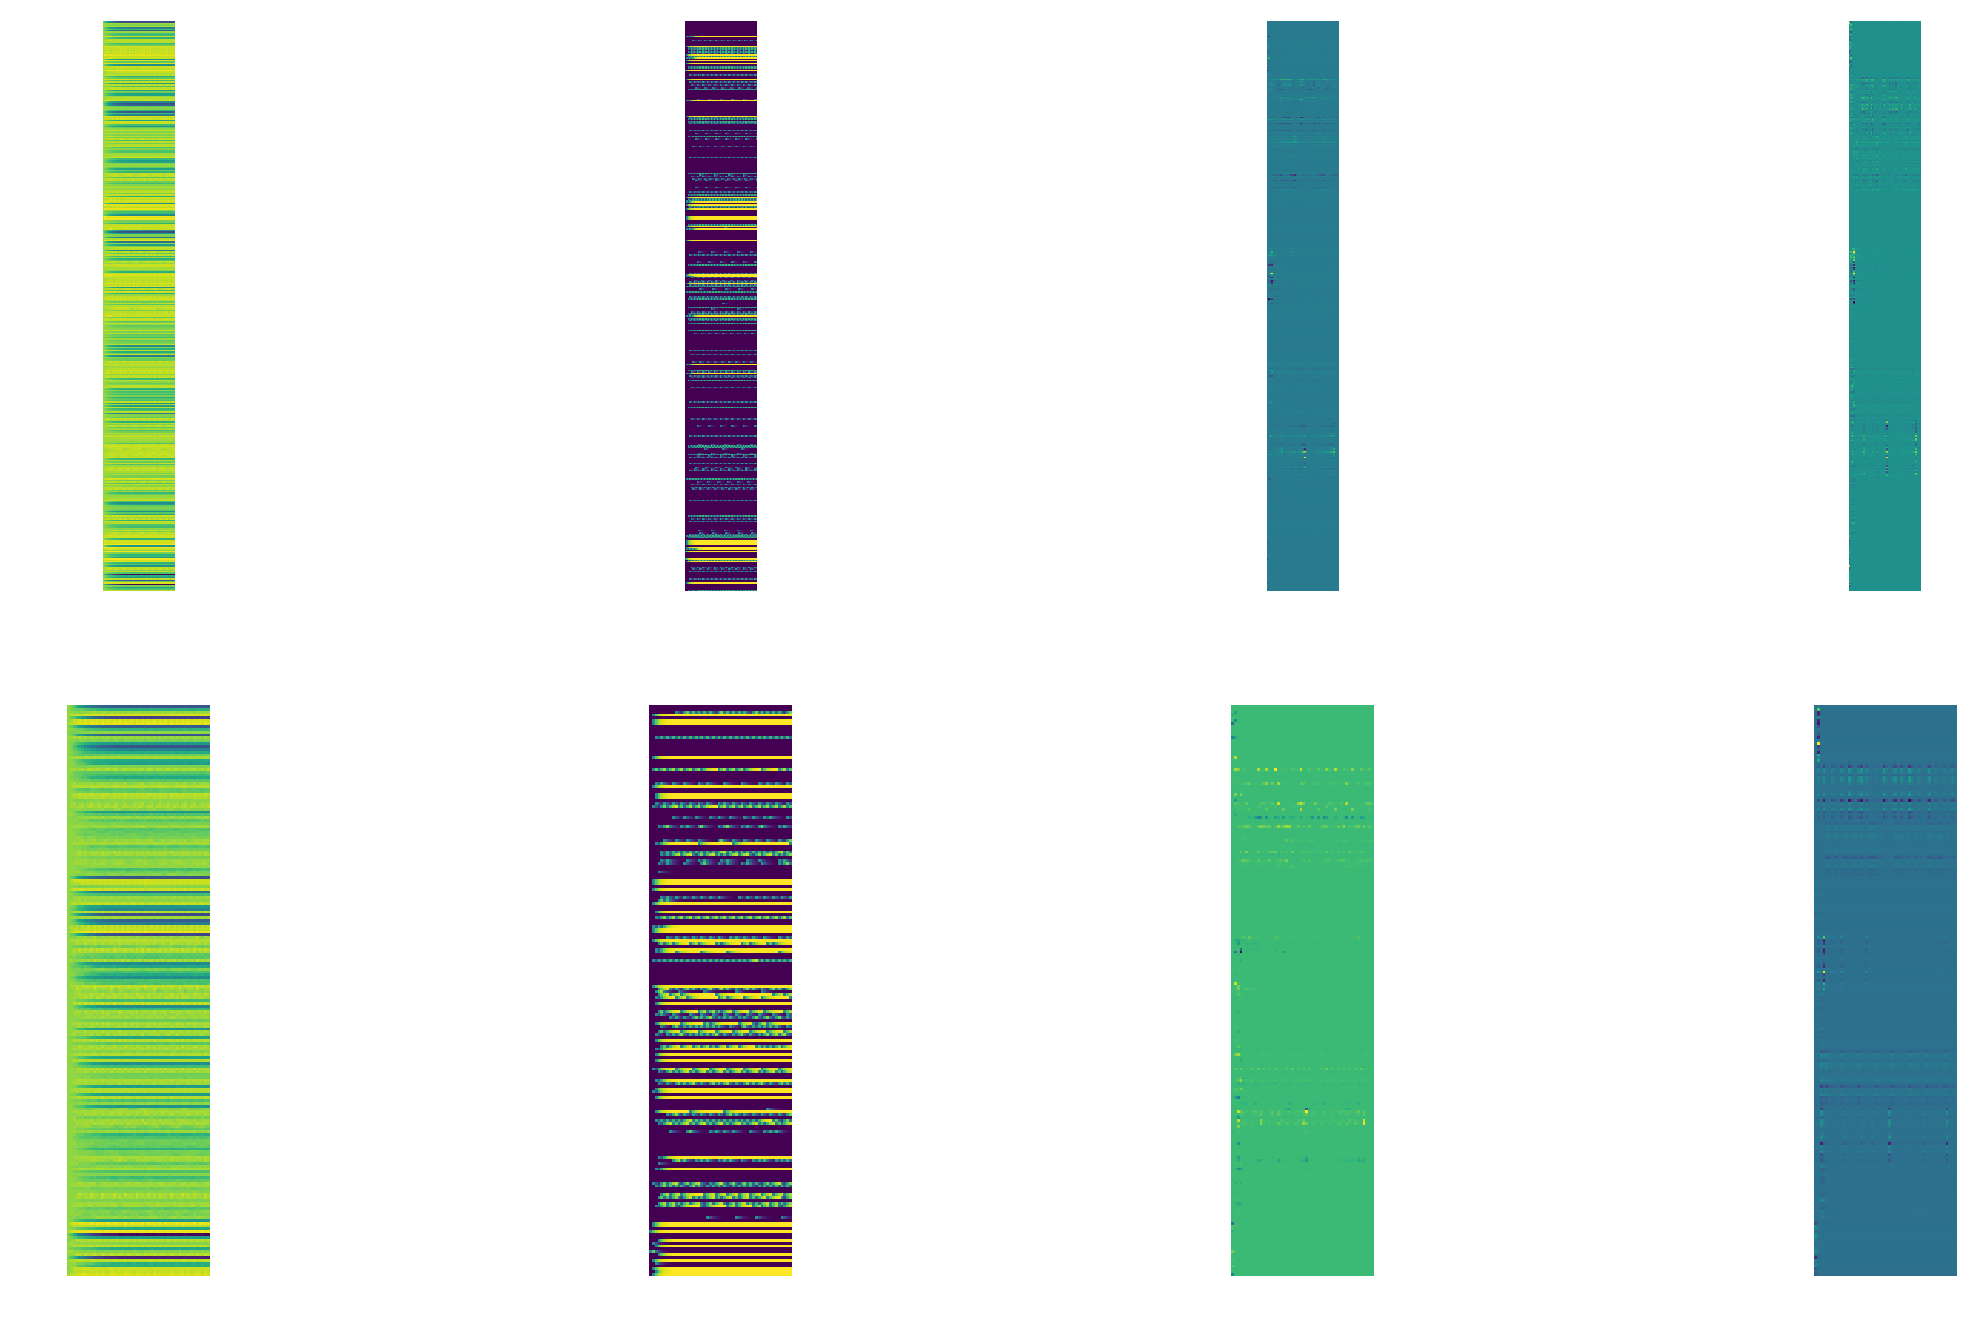

In [32]:
dtype = torch.float32
device = torch.device("cpu")

config_path = 'Config_files/XOR.yaml'
params = parse(config_path)


train_loader, test_loader = loadXOR.get_XOR(params['Network'])

network_config = params['Network']
n_steps = network_config['n_steps']
batch_size = network_config['batch_size']
epoch = 0
glv.init(params)

net = cnns.Network(params['Network'], params['Layers'],\
            list(train_loader.dataset[0][0].shape)).to(glv.device)

err = loss.SpikeLoss(params['Network']).to(glv.device)
optimizer = torch.optim.AdamW(net.get_parameters(),\
            lr=params['Network']['lr'], betas=(0.9, 0.999))
flag = 0
for batch_idx, (inputs, labels) in enumerate(train_loader):
    if flag == 1:
        break
    flag=1
targets = labels
inputs.type(dtype)
inputs = inputs.unsqueeze_(-1).repeat(1, 1, 1, 1, n_steps)
print(labels)
print(inputs.shape)
print(labels.shape)

%matplotlib qt5
plt.figure(figsize=(10,5))

for times_count in range(100):
    
    print("times_count:", times_count)
    save_fig('mem'+str(times_count))
    save_fig('out'+str(times_count))
    
    outputs = net.forward(inputs, True)
    plot_mov_fig()

    loss_num = err.average(outputs, targets)
    
    optimizer.zero_grad()

    loss_num.backward()
    plot_grad_fig()
    plt.pause(0.01)
    save_fig('err'+str(times_count))
    save_fig('gra'+str(times_count))
    optimizer.step()

tensor([[0.2500, 0.1250, 0.0625, 0.0312, 0.0156],
        [0.0000, 0.2500, 0.1250, 0.0625, 0.0312],
        [0.0000, 0.0000, 0.2500, 0.1250, 0.0625],
        [0.0000, 0.0000, 0.0000, 0.2500, 0.1250],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500]])


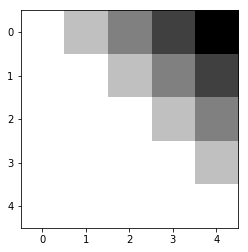

In [34]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
n_steps = 5
tau_s = 2
partial_a = torch.zeros((1, 1, 1, 1, n_steps, n_steps), dtype=dtype).to(device)
for t in range(n_steps):
    if t > 0:
        partial_a[..., t] = partial_a[..., t - 1] - partial_a[..., t - 1] / tau_s 
    partial_a[..., t, t] = 1/tau_s
partial_a /= tau_s


    
plt.imshow(torch.log(partial_a[0][0][0][0]), cmap='gray')
print(partial_a[0][0][0][0])
